<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/QUANT009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 首先安装TA-Lib系统依赖
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!make install
%cd ..

# 安装Python TA-Lib包
!pip install TA-Lib

# 安装其他必要的包
!pip install yfinance pandas numpy matplotlib

# 现在可以导入所需的库
import yfinance as yf
import pandas as pd
import numpy as np
import talib
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

--2024-11-29 18:13:39--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-11-29 18:13:39--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://gigenet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-11-29 18:13:39--  http://gigenet.dl.source

In [2]:
!apt-get update
!apt-get install -y fonts-wqy-zenhei

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,514 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,621 kB]
Fetched 11.4 MB in 2s (5,124 kB/s)
Reading package lists... Done
W: Skipping acquire of con

In [3]:
!pip install mplfinance

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import mplfinance as mpf

def format_hk_stock_code(symbol):
    symbol = symbol.replace('.HK', '')
    symbol = symbol.zfill(4)
    return f"{symbol}.HK"

def get_float_shares(symbol):
    """
    获取股票的流通股数
    """
    try:
        ticker = yf.Ticker(symbol)
        # 获取股票信息
        info = ticker.info

        # 尝试不同的字段来获取流通股数
        float_shares = None

        if 'sharesOutstanding' in info:
            # 流通股数
            float_shares = info['sharesOutstanding']
        #elif 'floatShares' in info:
        #    # 浮动股数
        #    float_shares = info['floatShares']
        elif 'marketCap' in info and 'currentPrice' in info and info['currentPrice'] > 0:
            # 如果没有直接的流通股数据，使用市值除以当前价格估算
            float_shares = info['marketCap'] / info['currentPrice']

        if float_shares is None:
            print(f"Warning: Could not get float shares for {symbol}, using default value")
            return None

        return float_shares

    except Exception as e:
        print(f"Error getting float shares: {e}")
        return None

def get_stock_data(symbol, start_date, end_date):

    symbol = format_hk_stock_code(symbol)
    print(f"Downloading data for {symbol}...")

    try:
        stock = yf.download(symbol, start=start_date, end=end_date, interval='1d')

        if stock.empty:
            print(f"No data available for {symbol}")
            return None

        df = stock.copy()

        # 获取股票的流通股数
        float_shares = get_float_shares(symbol)
        if float_shares is None:
            # 如果无法获取流通股数，使用成交量的移动平均值作为基准
            print("Using volume moving average as turnover rate base")
            float_shares = df['Volume'].rolling(window=30).mean().mean()

        # Calculate VWAP (成交量加权平均价格)
        df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
        ## Calculate VWAP
        #df['VWAP'] = df.apply(lambda x: (x['High'] + x['Low'] + x['Close']) / 3, axis=1)

        # Calculate MA5
        df['MA5'] = df['Close'].rolling(window=5).mean()

        # Calculate Change Ratio (今日收盘价-昨日收盘价)/昨日收盘价×100%
        df['Change_Ratio'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
        ## Calculate Change Ratio
        #df['Change_Ratio'] = df['Close'].pct_change() * 100

        # Calculate Turnover Rate using actual float shares
        df['Turnover_Rate'] = (df['Volume'] / float_shares) * 100
        ## Calculate Turnover Rate
        #df['Turnover_Rate'] = (df['Volume'] / df['Volume'].mean()) * 100

        # Calculate MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

        # Calculate KDJ
        low_min = df['Low'].rolling(window=9).min()
        high_max = df['High'].rolling(window=9).max()
        rsv = 100 * ((df['Close'] - low_min) / (high_max - low_min))
        df['K'] = rsv.ewm(com=2, adjust=False).mean()
        df['D'] = df['K'].ewm(com=2, adjust=False).mean()
        df['J'] = 3 * df['K'] - 2 * df['D']

        # Calculate EMV
        dm = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
        br = (df['Volume'] / 100000000) / ((df['High'] - df['Low']))
        emv = dm / br
        df['EMV'] = emv.rolling(14).mean()

        # Calculate RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        return df

    except Exception as e:
        print(f"Error occurred: {e}")
        return None


def print_stock_info(symbol):
    """
    打印股票的基本信息
    """
    symbol = format_hk_stock_code(symbol)
    ticker = yf.Ticker(symbol)
    info = ticker.info

    print(f"\nStock Information for {symbol}:")
    print("-" * 50)

    # 打印基本信息
    keys_to_print = [
        'longName', 'sector', 'industry',
        'marketCap', 'floatShares', 'sharesOutstanding',
        'volume', 'averageVolume',
        'currentPrice', 'previousClose',
        'fiftyDayAverage', 'twoHundredDayAverage'
    ]

    for key in keys_to_print:
        if key in info:
            print(f"{key}: {info[key]}")

# 测试代码
symbol = '1860'
start_date = '2024-09-20'
end_date = '2024-11-28'

# 打印股票信息
print_stock_info(symbol)

# 获取并处理数据
df = get_stock_data(symbol, start_date, end_date)

if df is not None:
    print("\nFirst few rows of processed data:")
    print(df[['Close', 'Volume', 'Change_Ratio', 'VWAP', 'Turnover_Rate']].head())



Stock Information for 1860.HK:
--------------------------------------------------
longName: MOBVISTA
sector: Communication Services
industry: Advertising Agencies
marketCap: 12009600000
floatShares: 394721625
sharesOutstanding: 1501200000
volume: 65198611
averageVolume: 38829843
currentPrice: 8.0
previousClose: 7.96
fiftyDayAverage: 3.2342
twoHundredDayAverage: 2.7166


[*********************100%***********************]  1 of 1 completed


First few rows of processed data:
Price                       Close   Volume Change_Ratio      VWAP  \
Ticker                    1860.HK  1860.HK                          
Date                                                                
2024-09-20 00:00:00+00:00    1.31  4601399          NaN  1.310000   
2024-09-23 00:00:00+00:00    1.30  2246000    -0.763358  1.306720   
2024-09-24 00:00:00+00:00    1.40  8804000     7.692310  1.359190   
2024-09-25 00:00:00+00:00    1.41  4287000     0.714285  1.370115   
2024-09-26 00:00:00+00:00    1.48  8497940     4.964543  1.402953   

Price                     Turnover_Rate  
Ticker                                   
Date                                     
2024-09-20 00:00:00+00:00      0.306515  
2024-09-23 00:00:00+00:00      0.149614  
2024-09-24 00:00:00+00:00      0.586464  
2024-09-25 00:00:00+00:00      0.285572  
2024-09-26 00:00:00+00:00      0.566076  


In [5]:
!pip install pandas numpy scikit-learn xgboost seaborn matplotlib

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import mplfinance as mpf


def create_sliding_windows(df, window_size=10, prediction_days=1):
    """
    创建滑动窗口数据集
    """
    features = []
    targets = []
    dates = []

    feature_columns = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'VWAP', 'MA5', 'Change_Ratio', 'Turnover_Rate',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'K', 'D', 'J', 'EMV', 'RSI'
    ]

    # 检查特征列是否存在
    missing_columns = [col for col in feature_columns if col not in df.columns]
    if missing_columns:
        print(f"警告: 以下列不存在于数据中: {missing_columns}")
        return None, None, None

    # 删除包含NaN的行
    df = df.dropna()

    if len(df) <= window_size + prediction_days:
        print("数据量不足以创建滑动窗口")
        return None, None, None

    for i in range(len(df) - window_size - prediction_days + 1):
        window_data = df[i:(i + window_size)][feature_columns].values

        # 检查窗口数据是否包含NaN
        if np.isnan(window_data).any():
            continue

        # 使用.iloc[0]来获取标量值
        target_price = df['Close'].iloc[i + window_size + prediction_days - 1].iloc[0]
        current_price = df['Close'].iloc[i + window_size - 1].iloc[0]
        price_change = (target_price - current_price) / current_price

        target = 1 if price_change > 0 else 0

        features.append(window_data)
        targets.append(target)
        dates.append(df.index[i + window_size])

    if not features:
        print("没有生成有效的特征数据")
        return None, None, None

    return np.array(features), np.array(targets), dates

def prepare_dataset(symbol, start_date, end_date, window_size=10, prediction_days=1):
    """
    准备完整的数据集
    """
    # 获取股票数据
    df = get_stock_data(symbol, start_date, end_date)

    if df is None or len(df) == 0:  # 修改这里的判断条件
        print("获取股票数据失败或数据为空")
        return None, None

    # 创建滑动窗口数据集
    X, y, dates = create_sliding_windows(df, window_size, prediction_days)

    if X is None or y is None or dates is None:
        return None, None

    # 计算每个样本的统计特征
    X_processed = []
    for window in X:
        window_features = []

        for col in range(window.shape[1]):
            col_data = window[:, col]

            # 基础统计特征
            window_features.extend([
                np.mean(col_data),
                np.std(col_data),
                np.min(col_data),
                np.max(col_data),
                np.percentile(col_data, 25),
                np.percentile(col_data, 75)
            ])

            # 安全地计算变化率
            if abs(col_data[0]) > 1e-6:
                change_rate = (col_data[-1] - col_data[0]) / col_data[0]
            else:
                change_rate = 0
            window_features.append(change_rate)

            # 5日动量和波动率
            if len(col_data) >= 5:
                momentum = (col_data[-1] - col_data[-5]) / col_data[-5] if abs(col_data[-5]) > 1e-6 else 0
                volatility = np.std(col_data[-5:]) / np.mean(col_data[-5:]) if np.mean(col_data[-5:]) > 1e-6 else 0
            else:
                momentum = 0
                volatility = 0

            window_features.extend([momentum, volatility])

        X_processed.append(window_features)

    X_processed = np.array(X_processed)

    # 创建特征名称
    feature_names = []
    base_features = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'VWAP', 'MA5', 'Change_Ratio', 'Turnover_Rate',
        'MACD', 'MACD_Signal', 'MACD_Hist',
        'K', 'D', 'J', 'EMV', 'RSI'
    ]
    stats = ['mean', 'std', 'min', 'max', 'percentile25', 'percentile75',
             'change_rate', 'momentum_5d', 'volatility_5d']

    for feat in base_features:
        for stat in stats:
            feature_names.append(f'{feat}_{stat}')

    return pd.DataFrame(X_processed, columns=feature_names, index=dates), pd.Series(y, index=dates)

def analyze_dataset(X_df, y_series):
    """
    分析数据集并打印结果
    """
    print("\n数据集信息:")
    print("特征形状:", X_df.shape)
    print("目标变量形状:", y_series.shape)
    print("\n特征示例:")
    print(X_df.head())
    print("\n样本分布:")
    print(y_series.value_counts(normalize=True))

    # 特征相关性分析
    correlation_matrix = X_df.corr()
    high_corr_features = np.where(np.abs(correlation_matrix) > 0.8)
    high_corr_pairs = set()

    for i, j in zip(*high_corr_features):
        if i != j:
            pair = tuple(sorted([correlation_matrix.index[i], correlation_matrix.columns[j]]))
            high_corr_pairs.add((pair[0], pair[1], correlation_matrix.iloc[i, j]))

    print("\n高相关性特征对 (前10个):")
    for feat1, feat2, corr in list(high_corr_pairs)[:10]:
        print(f"{feat1} - {feat2}: {corr:.3f}")

def main():
    symbol = '1860'
    start_date = '2024-07-28'
    end_date = '2024-11-28'

    X_df, y_series = prepare_dataset(
        symbol,
        start_date,
        end_date,
        window_size=10,
        prediction_days=1
    )


    if X_df is not None and y_series is not None and len(X_df) > 0:  # 修改这里的判断条件
        analyze_dataset(X_df, y_series)
    else:
        print("数据准备失败")


if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed


数据集信息:
特征形状: (60, 153)
目标变量形状: (60,)

特征示例:
                           Open_mean  Open_std  Open_min  Open_max  \
2024-08-30 00:00:00+00:00      1.613  0.155181      1.30      1.77   
2024-09-02 00:00:00+00:00      1.571  0.166160      1.30      1.77   
2024-09-03 00:00:00+00:00      1.531  0.163979      1.30      1.77   
2024-09-04 00:00:00+00:00      1.480  0.160997      1.26      1.71   
2024-09-05 00:00:00+00:00      1.437  0.153756      1.26      1.71   

                           Open_percentile25  Open_percentile75  \
2024-08-30 00:00:00+00:00             1.5200             1.7475   
2024-09-02 00:00:00+00:00             1.4350             1.7075   
2024-09-03 00:00:00+00:00             1.3725             1.6900   
2024-09-04 00:00:00+00:00             1.3450             1.6325   
2024-09-05 00:00:00+00:00             1.3100             1.5400   

                           Open_change_rate  Open_momentum_5d  \
2024-08-30 00:00:00+00:00         -0.261364         -0.216867   
2

[*********************100%***********************]  1 of 1 completed



Training model...


[*********************100%***********************]  1 of 1 completed



Making predictions...

Prediction Results:
                           Prediction  Probability_Up
2024-11-21 00:00:00+00:00           0            0.38
2024-11-22 00:00:00+00:00           0            0.36
2024-11-25 00:00:00+00:00           0            0.36
2024-11-26 00:00:00+00:00           0            0.37
2024-11-27 00:00:00+00:00           0            0.33

Training Set Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        48

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154



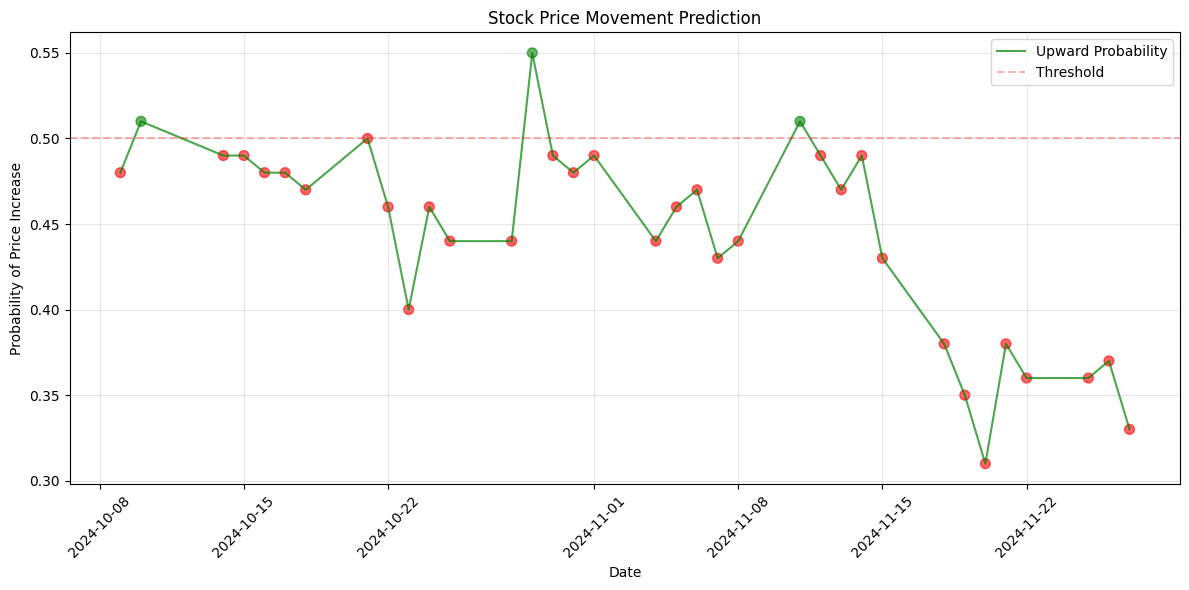

In [7]:
def main():
    # 1. 准备历史数据用于训练
    symbol = '1860'
    train_start_date = '2023-07-28'
    train_end_date = '2024-05-31'

    # 获取训练数据
    X_train_df, y_train = prepare_dataset(
        symbol,
        train_start_date,
        train_end_date,
        window_size=10,
        prediction_days=1
    )

    if X_train_df is None or y_train is None or len(X_train_df) == 0:
        print("Training data preparation failed")
        return

    # 2. 训练模型
    print("\nTraining model...")
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler

    # 标准化特征
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)

    # 创建和训练模型
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # 保存模型信息
    model_info = {
        'model': model,
        'scaler': scaler,
        'feature_names': X_train_df.columns.tolist()
    }

    # 3. 准备预测数据
    predict_start_date = '2024-09-01'
    predict_end_date = '2024-11-28'

    X_predict_df, _ = prepare_dataset(
        symbol,
        predict_start_date,
        predict_end_date,
        window_size=10,
        prediction_days=1
    )

    if X_predict_df is None or len(X_predict_df) == 0:
        print("Prediction data preparation failed")
        return

    # 4. 进行预测
    print("\nMaking predictions...")
    X_predict_scaled = scaler.transform(X_predict_df)
    probabilities = model.predict_proba(X_predict_scaled)
    predictions = pd.DataFrame({
        'Prediction': model.predict(X_predict_scaled),
        'Probability_Up': probabilities[:, 1]
    }, index=X_predict_df.index)

    # 5. 显示预测结果
    print("\nPrediction Results:")
    print(predictions.tail())

    # 6. 评估模型
    from sklearn.metrics import accuracy_score, classification_report
    if y_train is not None:
        train_predictions = model.predict(X_train_scaled)
        print("\nTraining Set Performance:")
        print(f"Accuracy: {accuracy_score(y_train, train_predictions):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_train, train_predictions))

    # 7. 绘制预测结果
    plot_predictions(predictions)

    return model_info, predictions

def plot_predictions(predictions):
    """
    Plot prediction results
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))

    # Plot upward probability
    plt.plot(predictions.index, predictions['Probability_Up'],
             label='Upward Probability', color='green', alpha=0.7)

    # Color based on predictions
    colors = ['red' if x == 0 else 'green' for x in predictions['Prediction']]
    plt.scatter(predictions.index, predictions['Probability_Up'],
               c=colors, s=50, alpha=0.6)

    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Threshold')
    plt.title('Stock Price Movement Prediction')
    plt.xlabel('Date')
    plt.ylabel('Probability of Price Increase')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    model_info, predictions = main()

    # Save model (optional)
    import joblib
    joblib.dump(model_info, 'stock_prediction_model.joblib')

In [8]:
!pip install plotly

In [9]:
def main():
    # 1. 准备历史数据用于训练
    symbol = '1860'
    train_start_date = '2023-07-28'
    train_end_date = '2023-11-27'

    # 获取训练数据
    X_train_df, y_train = prepare_dataset(
        symbol,
        train_start_date,
        train_end_date,
        window_size=10,
        prediction_days=1
    )

    if X_train_df is None or y_train is None or len(X_train_df) == 0:
        print("Training data preparation failed")
        return

    # 2. 训练模型
    print("\nTraining model...")
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler

    # 标准化特征
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)

    # 创建和训练模型
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # 保存模型信息
    model_info = {
        'model': model,
        'scaler': scaler,
        'feature_names': X_train_df.columns.tolist()
    }

    # 3. 准备预测数据
    predict_start_date = '2024-07-28'
    predict_end_date = '2024-11-27'

    X_predict_df, _ = prepare_dataset(
        symbol,
        predict_start_date,
        predict_end_date,
        window_size=10,
        prediction_days=1
    )

    if X_predict_df is None or len(X_predict_df) == 0:
        print("Prediction data preparation failed")
        return

    # 4. 进行预测
    print("\nMaking predictions...")
    X_predict_scaled = scaler.transform(X_predict_df)
    probabilities = model.predict_proba(X_predict_scaled)
    predictions = pd.DataFrame({
        'Prediction': model.predict(X_predict_scaled),
        'Probability_Up': probabilities[:, 1]
    }, index=X_predict_df.index)

    # 5. 显示预测结果
    print("\nPrediction Results:")
    print(predictions.tail())

    # 6. 评估模型
    from sklearn.metrics import accuracy_score, classification_report
    if y_train is not None:
        train_predictions = model.predict(X_train_scaled)
        print("\nTraining Set Performance:")
        print(f"Accuracy: {accuracy_score(y_train, train_predictions):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_train, train_predictions, digits=5))

    # 7. 绘制预测结果
    plot_predictions_plotly(predictions)

    return model_info, predictions

def plot_predictions_plotly(predictions):
    """
    Plot prediction results using plotly
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add probability line
    fig.add_trace(
        go.Scatter(
            x=predictions.index,
            y=predictions['Probability_Up'],
            name="Upward Probability",
            line=dict(color="rgba(0, 128, 0, 0.7)"),
            mode='lines'
        )
    )

    # Add scatter points colored by prediction
    colors = ['red' if x == 0 else 'green' for x in predictions['Prediction']]
    fig.add_trace(
        go.Scatter(
            x=predictions.index,
            y=predictions['Probability_Up'],
            mode='markers',
            name='Predictions',
            marker=dict(
                color=colors,
                size=8,
                opacity=0.6
            ),
            showlegend=False
        )
    )

    # Add threshold line
    fig.add_trace(
        go.Scatter(
            x=[predictions.index[0], predictions.index[-1]],
            y=[0.5, 0.5],
            name="Threshold",
            line=dict(dash='dash', color='rgba(255, 0, 0, 0.3)')
        )
    )

    # Update layout
    fig.update_layout(
        title='Stock Price Movement Prediction',
        xaxis_title='Date',
        yaxis_title='Probability of Price Increase',
        hovermode='x unified',
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    # Add range slider
    fig.update_xaxes(rangeslider_visible=True)

    # Show figure
    fig.show()

if __name__ == "__main__":
    model_info, predictions = main()

    # Save model (optional)
    import joblib
    joblib.dump(model_info, 'stock_prediction_model.joblib')

[*********************100%***********************]  1 of 1 completed


Training model...


[*********************100%***********************]  1 of 1 completed


Making predictions...

Prediction Results:
                           Prediction  Probability_Up
2024-11-20 00:00:00+00:00           0            0.45
2024-11-21 00:00:00+00:00           1            0.52
2024-11-22 00:00:00+00:00           0            0.47
2024-11-25 00:00:00+00:00           0            0.45
2024-11-26 00:00:00+00:00           0            0.41

Training Set Performance:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        39
           1    1.00000   1.00000   1.00000        19

    accuracy                        1.00000        58
   macro avg    1.00000   1.00000   1.00000        58
weighted avg    1.00000   1.00000   1.00000        58



In [10]:
def main():
    # 1. 准备历史数据用于训练
    symbol = '1860'
    train_start_date = '2023-07-28'
    train_end_date = '2023-11-27'

    # 获取训练数据
    X_df, y = prepare_dataset(
        symbol,
        train_start_date,
        train_end_date,
        window_size=10,
        prediction_days=1
    )

    if X_df is None or y is None or len(X_df) == 0:
        print("Data preparation failed")
        return

    # 2. 划分训练集和验证集
    from sklearn.model_selection import train_test_split

    # 使用20%的数据作为验证集
    X_train_df, X_val_df, y_train, y_val = train_test_split(
        X_df,
        y,
        test_size=0.2,
        random_state=42,
        shuffle=True  # 随机打乱数据
    )

    # 3. 训练模型
    print("\nTraining model...")
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    # 标准化特征
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_val_scaled = scaler.transform(X_val_df)

    # 创建和训练模型
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # 4. 评估模型
    print("\nModel Evaluation:")

    # 在训练集上的表现
    train_predictions = model.predict(X_train_scaled)
    train_probabilities = model.predict_proba(X_train_scaled)
    print("\nTraining Set Performance:")
    print(f"Accuracy: {accuracy_score(y_train, train_predictions):.4f}")
    print("\nTraining Set Classification Report:")
    print(classification_report(y_train, train_predictions, digits=5))

    # 在验证集上的表现
    val_predictions = model.predict(X_val_scaled)
    val_probabilities = model.predict_proba(X_val_scaled)
    print("\nValidation Set Performance:")
    print(f"Accuracy: {accuracy_score(y_val, val_predictions):.4f}")
    print("\nValidation Set Classification Report:")
    print(classification_report(y_val, val_predictions, digits=5))

    # 打印混淆矩阵
    print("\nValidation Set Confusion Matrix:")
    print(confusion_matrix(y_val, val_predictions))

    # 保存模型信息
    model_info = {
        'model': model,
        'scaler': scaler,
        'feature_names': X_train_df.columns.tolist()
    }

    # 5. 准备预测数据
    predict_start_date = '2024-07-28'
    predict_end_date = '2024-11-27'

    X_predict_df, y_actual = prepare_dataset(
        symbol,
        predict_start_date,
        predict_end_date,
        window_size=10,
        prediction_days=1
    )

    if X_predict_df is None or len(X_predict_df) == 0:
        print("Prediction data preparation failed")
        return

    # 6. 进行预测
    print("\nMaking predictions...")
    X_predict_scaled = scaler.transform(X_predict_df)
    probabilities = model.predict_proba(X_predict_scaled)
    #predictions = pd.DataFrame({
    #    'Prediction': model.predict(X_predict_scaled),
    #    'Probability_Up': probabilities[:, 1]
    #}, index=X_predict_df.index)

    # 创建预测结果DataFrame（索引往后移动一天）
    next_day_index = X_predict_df.index + pd.Timedelta(days=1)
    predictions = pd.DataFrame({
        'Prediction': model.predict(X_predict_scaled),
        'Probability_Up': probabilities[:, 1]
    }, index=next_day_index)


    #actual_prices = get_actual_prices(symbol, X_predict_df.index[0], X_predict_df.index[-1])
    # 获取实际价格数据（包括多获取一天的数据以便对齐）
    actual_prices = get_actual_prices(
        symbol,
        X_predict_df.index[0],
        X_predict_df.index[-1] + pd.Timedelta(days=1)
    )

    ## 确保y_actual是一维数组
    #if y_actual is not None:
    #    y_actual = y_actual.to_numpy().flatten()

    #if y_actual is not None:
    #    predictions['Actual_Direction'] = y_actual

    ## 添加实际价格数据
    #if actual_prices is not None:
    #    predictions['Close_Price'] = actual_prices['Close']
    #    predictions['Price_Change'] = actual_prices['Close'].pct_change()


    # 添加实际价格数据和涨跌幅
    if actual_prices is not None:
        predictions['Close_Price'] = actual_prices['Close']
        predictions['Price_Change'] = actual_prices['Close'].pct_change()
        # 计算实际涨跌方向（1表示上涨，0表示下跌）
        predictions['Actual_Direction'] = (predictions['Price_Change'] > 0).astype(int)

        # 计算预测准确率
        predictions['Correct'] = (predictions['Prediction'] == predictions['Actual_Direction'])
        accuracy = predictions['Correct'].mean()
        print(f"\nOverall Prediction Accuracy: {accuracy:.4f}")

        # 添加更多的评估指标
        from sklearn.metrics import classification_report, confusion_matrix
        print("\nClassification Report:")
        print(classification_report(
            predictions['Actual_Direction'].dropna(),
            predictions['Prediction'].reindex(predictions['Actual_Direction'].dropna().index)
        ))

        print("\nConfusion Matrix:")
        print(confusion_matrix(
            predictions['Actual_Direction'].dropna(),
            predictions['Prediction'].reindex(predictions['Actual_Direction'].dropna().index)
        ))



    # 7. 显示预测结果
    print("\nPrediction Results:")
    print(predictions.tail())

    # 8. 绘制预测结果
    plot_predictions_plotly(predictions)

    # 9. 特征重要性分析
    feature_importance = pd.DataFrame({
        'feature': X_train_df.columns,
        'importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    return model_info, predictions, feature_importance


def plot_predictions_plotly(predictions):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # 创建包含两个子图的图表
    fig = make_subplots(rows=2, cols=1,
                        vertical_spacing=0.1,
                        subplot_titles=('Stock Price and Predictions', 'Prediction Probability'))

    # 添加股票价格
    fig.add_trace(
        go.Scatter(x=predictions.index,
                  y=predictions['Close_Price'],
                  mode='lines',
                  name='Close Price'),
        row=1, col=1
    )

    # 添加预测概率
    fig.add_trace(
        go.Scatter(x=predictions.index,
                  y=predictions['Probability_Up'],
                  mode='markers',
                  name='Up Probability',
                  marker=dict(
                      color=predictions['Prediction'].map({1: 'green', 0: 'red'}),
                      size=8
                  )),
        row=2, col=1
    )

    # 添加实际涨跌标记
    if 'Actual_Direction' in predictions.columns:
        fig.add_trace(
            go.Scatter(x=predictions.index,
                      y=predictions['Close_Price'],
                      mode='markers',
                      name='Actual Direction',
                      marker=dict(
                          color=predictions['Actual_Direction'].map({1: 'green', 0: 'red'}),
                          size=8,
                          symbol='star'
                      )),
            row=1, col=1
        )

    # 添加0.5的参考线
    fig.add_hline(y=0.5, line_dash="dash", line_color="gray", row=2, col=1)

    # 更新布局
    fig.update_layout(
        title='Stock Price Predictions Analysis',
        height=800,
        showlegend=True
    )

    # 更新y轴标题
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Probability", range=[0, 1], row=2, col=1)

    fig.show()

def get_actual_prices(symbol, start_date, end_date):
    """
    获取实际的股价数据
    """
    # 使用现有的get_stock_data函数获取数据
    df = get_stock_data(symbol, start_date, end_date)

    if df is None:
        return None

    # 直接选择需要的列创建新的DataFrame
    price_data = df[['Close', 'High', 'Low', 'Volume', 'Change_Ratio']].copy()

    return price_data

if __name__ == "__main__":
    model_info, predictions, feature_importance = main()

    # Save model (optional)
    import joblib
    joblib.dump(model_info, 'stock_prediction_model.joblib')

[*********************100%***********************]  1 of 1 completed


Training model...


[*********************100%***********************]  1 of 1 completed


Model Evaluation:

Training Set Performance:
Accuracy: 1.0000

Training Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        29
           1    1.00000   1.00000   1.00000        17

    accuracy                        1.00000        46
   macro avg    1.00000   1.00000   1.00000        46
weighted avg    1.00000   1.00000   1.00000        46


Validation Set Performance:
Accuracy: 0.7500

Validation Set Classification Report:
              precision    recall  f1-score   support

           0    0.81818   0.90000   0.85714        10
           1    0.00000   0.00000   0.00000         2

    accuracy                        0.75000        12
   macro avg    0.40909   0.45000   0.42857        12
weighted avg    0.68182   0.75000   0.71429        12


Validation Set Confusion Matrix:
[[9 1]
 [2 0]]



[*********************100%***********************]  1 of 1 completed


Making predictions...



Overall Prediction Accuracy: 0.5085

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.33      0.47        39
           1       0.40      0.85      0.54        20

    accuracy                           0.51        59
   macro avg       0.60      0.59      0.51        59
weighted avg       0.67      0.51      0.50        59


Confusion Matrix:
[[13 26]
 [ 3 17]]

Prediction Results:
                           Prediction  Probability_Up  Close_Price  \
2024-11-21 00:00:00+00:00           0            0.45         7.74   
2024-11-22 00:00:00+00:00           0            0.49         8.64   
2024-11-23 00:00:00+00:00           0            0.46          NaN   
2024-11-26 00:00:00+00:00           0            0.43         8.21   
2024-11-27 00:00:00+00:00           0            0.42          NaN   

                           Price_Change  Actual_Direction  Correct  
2024-11-21 00:00:00+00:00     -0.075269                 0     T


Top 10 Most Important Features:
                       feature  importance
151            RSI_momentum_5d    0.034141
68   Change_Ratio_percentile75    0.032409
33           Close_change_rate    0.024860
8           Open_volatility_5d    0.024089
43          Volume_momentum_5d    0.020576
127                      J_std    0.019976
16            High_momentum_5d    0.019405
136                    EMV_std    0.018393
141            EMV_change_rate    0.017056
124              D_momentum_5d    0.016891


In [11]:
def main():
    # 1. 准备历史数据用于训练
    symbol = '1860'
    train_start_date = '2023-07-28'
    train_end_date = '2023-11-27'

    # 获取训练数据
    X_df, y = prepare_dataset(
        symbol,
        train_start_date,
        train_end_date,
        window_size=10,
        prediction_days=1
    )

    if X_df is None or y is None or len(X_df) == 0:
        print("Data preparation failed")
        return

    # 2. 划分训练集和验证集
    from sklearn.model_selection import train_test_split

    # 使用20%的数据作为验证集
    X_train_df, X_val_df, y_train, y_val = train_test_split(
        X_df,
        y,
        test_size=0.2,
        random_state=42,
        shuffle=True  # 随机打乱数据
    )

    # 3. 训练模型
    print("\nTraining model...")
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    # 标准化特征
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_val_scaled = scaler.transform(X_val_df)

    # 创建和训练模型
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # 4. 评估模型
    print("\nModel Evaluation:")

    # 在训练集上的表现
    train_predictions = model.predict(X_train_scaled)
    train_probabilities = model.predict_proba(X_train_scaled)
    print("\nTraining Set Performance:")
    print(f"Accuracy: {accuracy_score(y_train, train_predictions):.4f}")
    print("\nTraining Set Classification Report:")
    print(classification_report(y_train, train_predictions, digits=5))

    # 在验证集上的表现
    val_predictions = model.predict(X_val_scaled)
    val_probabilities = model.predict_proba(X_val_scaled)
    print("\nValidation Set Performance:")
    print(f"Accuracy: {accuracy_score(y_val, val_predictions):.4f}")
    print("\nValidation Set Classification Report:")
    print(classification_report(y_val, val_predictions, digits=5))

    # 打印混淆矩阵
    print("\nValidation Set Confusion Matrix:")
    print(confusion_matrix(y_val, val_predictions))

    # 保存模型信息
    model_info = {
        'model': model,
        'scaler': scaler,
        'feature_names': X_train_df.columns.tolist()
    }

    # 5. 准备预测数据
    predict_start_date = '2024-07-28'
    predict_end_date = '2024-11-27'

    X_predict_df, y_actual = prepare_dataset(
        symbol,
        predict_start_date,
        predict_end_date,
        window_size=10,
        prediction_days=1
    )

    if X_predict_df is None or len(X_predict_df) == 0:
        print("Prediction data preparation failed")
        return

    # 6. 进行预测
    print("\nMaking predictions...")
    X_predict_scaled = scaler.transform(X_predict_df)
    probabilities = model.predict_proba(X_predict_scaled)
    #predictions = pd.DataFrame({
    #    'Prediction': model.predict(X_predict_scaled),
    #    'Probability_Up': probabilities[:, 1]
    #}, index=X_predict_df.index)

    # 创建预测结果DataFrame（索引往后移动一天）
    next_day_index = X_predict_df.index + pd.Timedelta(days=1)
    predictions = pd.DataFrame({
        'Prediction': model.predict(X_predict_scaled),
        'Probability_Up': probabilities[:, 1]
    }, index=next_day_index)


    #actual_prices = get_actual_prices(symbol, X_predict_df.index[0], X_predict_df.index[-1])
    # 获取实际价格数据（包括多获取一天的数据以便对齐）
    actual_prices = get_actual_prices(
        symbol,
        X_predict_df.index[0],
        X_predict_df.index[-1] + pd.Timedelta(days=1)
    )

    ## 确保y_actual是一维数组
    #if y_actual is not None:
    #    y_actual = y_actual.to_numpy().flatten()

    #if y_actual is not None:
    #    predictions['Actual_Direction'] = y_actual

    ## 添加实际价格数据
    #if actual_prices is not None:
    #    predictions['Close_Price'] = actual_prices['Close']
    #    predictions['Price_Change'] = actual_prices['Close'].pct_change()


    # 添加实际价格数据和涨跌幅
    if actual_prices is not None:
        predictions['Close_Price'] = actual_prices['Close']
        predictions['Price_Change'] = actual_prices['Close'].pct_change()
        # 计算实际涨跌方向（1表示上涨，0表示下跌）
        predictions['Actual_Direction'] = (predictions['Price_Change'] > 0).astype(int)

        # 计算预测准确率
        predictions['Correct'] = (predictions['Prediction'] == predictions['Actual_Direction'])
        accuracy = predictions['Correct'].mean()
        print(f"\nOverall Prediction Accuracy: {accuracy:.4f}")

        # 添加更多的评估指标
        from sklearn.metrics import classification_report, confusion_matrix
        print("\nClassification Report:")
        print(classification_report(
            predictions['Actual_Direction'].dropna(),
            predictions['Prediction'].reindex(predictions['Actual_Direction'].dropna().index)
        ))

        print("\nConfusion Matrix:")
        print(confusion_matrix(
            predictions['Actual_Direction'].dropna(),
            predictions['Prediction'].reindex(predictions['Actual_Direction'].dropna().index)
        ))



    # 7. 显示预测结果
    print("\nPrediction Results:")
    print(predictions.tail())

    # 8. 绘制预测结果
    plot_predictions_plotly(predictions)

    # 9. 特征重要性分析
    feature_importance = pd.DataFrame({
        'feature': X_train_df.columns,
        'importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    return model_info, predictions, feature_importance


def plot_predictions_plotly(predictions):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd
    import numpy as np

    # 确保predictions的索引是datetime类型
    if not isinstance(predictions.index, pd.DatetimeIndex):
        predictions.index = pd.to_datetime(predictions.index)

    # 创建数据的副本以避免修改原始数据
    df = predictions.copy()

    # 确保'Correct'列的值是布尔类型
    if 'Correct' in df.columns:
        df['Correct'] = df['Correct'].astype(float).fillna(0).astype(bool)

    # 创建图表
    fig = make_subplots(rows=2, cols=1,
                        vertical_spacing=0.1,
                        subplot_titles=('Stock Price and Predictions', 'Prediction Probability'))

    # 添加股票价格线
    fig.add_trace(
        go.Scatter(x=df.index,
                  y=df['Close_Price'],
                  mode='lines',
                  name='Close Price',
                  line=dict(color='gray')),
        row=1, col=1
    )

    # 添加预测正确性标记
    if 'Correct' in df.columns:
        # 创建掩码而不是直接过滤
        correct_mask = df['Correct'] == True
        wrong_mask = df['Correct'] == False

        # 添加正确预测的标记
        correct_indices = df.index[correct_mask]
        if len(correct_indices) > 0:
            fig.add_trace(
                go.Scatter(
                    x=correct_indices,
                    y=df.loc[correct_indices, 'Close_Price'],
                    mode='markers',
                    name='Correct Prediction (✓)',
                    marker=dict(
                        symbol='star',
                        size=12,
                        color='green',
                        line=dict(color='darkgreen', width=1)
                    )
                ),
                row=1, col=1
            )

        # 添加错误预测的标记
        wrong_indices = df.index[wrong_mask]
        if len(wrong_indices) > 0:
            fig.add_trace(
                go.Scatter(
                    x=wrong_indices,
                    y=df.loc[wrong_indices, 'Close_Price'],
                    mode='markers',
                    name='Wrong Prediction (×)',
                    marker=dict(
                        symbol='x',
                        size=12,
                        color='red',
                        line=dict(color='darkred', width=1)
                    )
                ),
                row=1, col=1
            )

        # 添加预测概率点
        if len(correct_indices) > 0:
            fig.add_trace(
                go.Scatter(
                    x=correct_indices,
                    y=df.loc[correct_indices, 'Probability_Up'],
                    mode='markers',
                    name='Correct Prob',
                    marker=dict(
                        symbol='circle',
                        size=8,
                        color='green',
                        line=dict(color='darkgreen', width=1)
                    )
                ),
                row=2, col=1
            )

        if len(wrong_indices) > 0:
            fig.add_trace(
                go.Scatter(
                    x=wrong_indices,
                    y=df.loc[wrong_indices, 'Probability_Up'],
                    mode='markers',
                    name='Wrong Prob',
                    marker=dict(
                        symbol='circle',
                        size=8,
                        color='red',
                        line=dict(color='darkred', width=1)
                    )
                ),
                row=2, col=1
            )

    # 添加0.5的参考线
    fig.add_hline(y=0.5, line_dash="dash", line_color="gray", row=2, col=1)

    # 计算准确率统计
    if 'Correct' in df.columns:
        # 使用numpy来计算统计数据
        valid_predictions = df['Correct'].notna()
        total_predictions = np.sum(valid_predictions)
        correct_predictions = np.sum(df['Correct'][valid_predictions])
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

        # 添加准确率注释
        fig.add_annotation(
            text=f"Accuracy: {accuracy:.2%} ({int(correct_predictions)}/{total_predictions})",
            xref="paper", yref="paper",
            x=1, y=1.1,
            showarrow=False,
            font=dict(size=14)
        )

    # 更新布局
    fig.update_layout(
        title='Stock Price Predictions Analysis',
        height=800,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # 更新y轴标题
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="Probability", range=[0, 1], row=2, col=1)

    # 更新x轴格式
    fig.update_xaxes(
        tickformat="%Y-%m-%d",
        tickangle=45,
        row=1, col=1
    )
    fig.update_xaxes(
        tickformat="%Y-%m-%d",
        tickangle=45,
        row=2, col=1
    )

    fig.show()

    # 输出详细的预测统计信息
    print("\nPrediction Statistics:")
    print(f"Total Predictions: {total_predictions}")
    print(f"Correct Predictions: {int(correct_predictions)}")
    print(f"Wrong Predictions: {total_predictions - int(correct_predictions)}")
    print(f"Accuracy: {accuracy:.2%}")

    # 计算连续正确和错误预测的最大次数
    if total_predictions > 0:
        try:
            # 创建一个布尔序列
            streak_series = pd.Series(df['Correct'][valid_predictions])
            # 计算变化点
            changes = (streak_series != streak_series.shift()).cumsum()
            # 计算每个序列的长度
            streaks = streak_series.groupby(changes).count()

            # 分别计算正确和错误预测的最长序列
            max_correct_streak = streaks[streak_series.groupby(changes).first()].max()
            max_wrong_streak = streaks[~streak_series.groupby(changes).first()].max()

            print(f"\nMax Consecutive Correct Predictions: {max_correct_streak}")
            print(f"Max Consecutive Wrong Predictions: {max_wrong_streak}")
        except Exception as e:
            print("\nUnable to calculate streak statistics:", str(e))


def get_actual_prices(symbol, start_date, end_date):
    """
    获取实际的股价数据
    """
    # 使用现有的get_stock_data函数获取数据
    df = get_stock_data(symbol, start_date, end_date)

    if df is None:
        return None

    # 直接选择需要的列创建新的DataFrame
    price_data = df[['Close', 'High', 'Low', 'Volume', 'Change_Ratio']].copy()

    return price_data

if __name__ == "__main__":
    model_info, predictions, feature_importance = main()

    # Save model (optional)
    import joblib
    joblib.dump(model_info, 'stock_prediction_model.joblib')

[*********************100%***********************]  1 of 1 completed


Training model...


[*********************100%***********************]  1 of 1 completed


Model Evaluation:

Training Set Performance:
Accuracy: 1.0000

Training Set Classification Report:
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        29
           1    1.00000   1.00000   1.00000        17

    accuracy                        1.00000        46
   macro avg    1.00000   1.00000   1.00000        46
weighted avg    1.00000   1.00000   1.00000        46


Validation Set Performance:
Accuracy: 0.7500

Validation Set Classification Report:
              precision    recall  f1-score   support

           0    0.81818   0.90000   0.85714        10
           1    0.00000   0.00000   0.00000         2

    accuracy                        0.75000        12
   macro avg    0.40909   0.45000   0.42857        12
weighted avg    0.68182   0.75000   0.71429        12


Validation Set Confusion Matrix:
[[9 1]
 [2 0]]



[*********************100%***********************]  1 of 1 completed


Making predictions...



Overall Prediction Accuracy: 0.5085

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.33      0.47        39
           1       0.40      0.85      0.54        20

    accuracy                           0.51        59
   macro avg       0.60      0.59      0.51        59
weighted avg       0.67      0.51      0.50        59


Confusion Matrix:
[[13 26]
 [ 3 17]]

Prediction Results:
                           Prediction  Probability_Up  Close_Price  \
2024-11-21 00:00:00+00:00           0            0.45         7.74   
2024-11-22 00:00:00+00:00           0            0.49         8.64   
2024-11-23 00:00:00+00:00           0            0.46          NaN   
2024-11-26 00:00:00+00:00           0            0.43         8.21   
2024-11-27 00:00:00+00:00           0            0.42          NaN   

                           Price_Change  Actual_Direction  Correct  
2024-11-21 00:00:00+00:00     -0.075269                 0     T


Prediction Statistics:
Total Predictions: 59
Correct Predictions: 30
Wrong Predictions: 29
Accuracy: 50.85%

Max Consecutive Correct Predictions: 4
Max Consecutive Wrong Predictions: 7

Top 10 Most Important Features:
                       feature  importance
151            RSI_momentum_5d    0.034141
68   Change_Ratio_percentile75    0.032409
33           Close_change_rate    0.024860
8           Open_volatility_5d    0.024089
43          Volume_momentum_5d    0.020576
127                      J_std    0.019976
16            High_momentum_5d    0.019405
136                    EMV_std    0.018393
141            EMV_change_rate    0.017056
124              D_momentum_5d    0.016891


In [12]:
# 添加必要的导入
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

def prepare_sequential_dataset(price_data, info, window_size=10, prediction_days=1):
    """准备序列预测数据集"""
    try:
        # 处理输入数据
        if price_data is None:
            print("输入数据为空")
            return None, None

        # 如果price_data是元组，获取正确的DataFrame
        if isinstance(price_data, tuple):
            if len(price_data) > 0:
                # 获取第一个元素，通常是DataFrame
                df = price_data[0]
                if isinstance(df, pd.DataFrame):
                    df = df.copy()
                else:
                    print(f"元组中的第一个元素不是DataFrame: {type(df)}")
                    return None, None
            else:
                print("输入的元组为空")
                return None, None
        elif isinstance(price_data, pd.DataFrame):
            df = price_data.copy()
        else:
            print(f"不支持的数据类型: {type(price_data)}")
            return None, None

        if len(df) == 0:
            print("DataFrame为空")
            return None, None

        print(f"原始DataFrame shape: {df.shape}")
        print("原始列名:", df.columns.tolist())

        # 重命名列，处理多级索引
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
        print("处理后的列名:", df.columns.tolist())

        # 获取流通股数
        float_shares = None
        try:
            if isinstance(info, dict):
                if 'sharesOutstanding' in info and info['sharesOutstanding']:
                    float_shares = info['sharesOutstanding']
                elif 'marketCap' in info and 'currentPrice' in info and info['currentPrice'] > 0:
                    float_shares = info['marketCap'] / info['currentPrice']
        except Exception as e:
            print(f"获取流通股数时出错: {str(e)}")

        if float_shares is None:
            print("使用成交量移动平均值作为换手率基准")
            float_shares = df['Volume'].rolling(window=30).mean().mean()

        # 计算技术指标
        try:
            # 基础指标
            df['MA5'] = df['Close'].rolling(window=5).mean()
            df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
            df['Change_Ratio'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
            df['Turnover_Rate'] = (df['Volume'] / float_shares) * 100

            # MACD
            exp1 = df['Close'].ewm(span=12, adjust=False).mean()
            exp2 = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = exp1 - exp2
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

            # KDJ
            low_min = df['Low'].rolling(window=9).min()
            high_max = df['High'].rolling(window=9).max()
            df['K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
            df['D'] = df['K'].rolling(window=3).mean()
            df['J'] = 3 * df['K'] - 2 * df['D']

            # EMV
            distance = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
            box_ratio = (df['Volume'] / 100000000) / (df['High'] - df['Low'])
            df['EMV'] = distance / box_ratio

            # RSI
            delta = df['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            df['RSI'] = 100 - (100 / (1 + gain / loss))

        except Exception as e:
            print(f"计算技术指标时出错: {str(e)}")
            return None, None

        # 删除NaN值并检查数据充分性
        df = df.dropna()
        if len(df) <= window_size + prediction_days:
            print("数据量不足以创建滑动窗口")
            return None, None

        # 准备特征和标签
        X = []
        y = []
        dates = []
        feature_columns = df.columns.tolist()

        for i in range(len(df) - window_size - prediction_days + 1):
            try:
                window_data = df[i:(i + window_size)][feature_columns].values
                if np.isnan(window_data).any():
                    continue

                # 计算窗口特征
                window_features = []
                for col in range(window_data.shape[1]):
                    col_data = window_data[:, col]

                    # 基础统计特征
                    window_features.extend([
                        np.mean(col_data),
                        np.std(col_data),
                        np.min(col_data),
                        np.max(col_data),
                        np.percentile(col_data, 25),
                        np.percentile(col_data, 75)
                    ])

                    # 变化率
                    change_rate = (col_data[-1] - col_data[0]) / col_data[0] if abs(col_data[0]) > 1e-6 else 0
                    window_features.append(change_rate)

                    # 5日动量和波动率
                    if len(col_data) >= 5:
                        momentum = (col_data[-1] - col_data[-5]) / col_data[-5] if abs(col_data[-5]) > 1e-6 else 0
                        volatility = np.std(col_data[-5:]) / np.mean(col_data[-5:]) if np.mean(col_data[-5:]) > 1e-6 else 0
                    else:
                        momentum = volatility = 0
                    window_features.extend([momentum, volatility])

                # 计算目标值
                target_price = df['Close'].iloc[i + window_size + prediction_days - 1]
                current_price = df['Close'].iloc[i + window_size - 1]
                target = 1 if (target_price - current_price) / current_price > 0 else 0

                X.append(window_features)
                y.append(target)
                dates.append(df.index[i + window_size])

            except Exception as e:
                print(f"处理第 {i} 个样本时出错: {str(e)}")
                continue

        if not X:
            print("没有生成有效的特征数据")
            return None, None

        # 创建最终的DataFrame
        feature_names = []
        stats = ['mean', 'std', 'min', 'max', 'percentile25', 'percentile75',
                'change_rate', 'momentum_5d', 'volatility_5d']

        for feat in feature_columns:
            for stat in stats:
                feature_names.append(f'{feat}_{stat}')

        X_df = pd.DataFrame(np.array(X), columns=feature_names, index=dates)
        y_series = pd.Series(np.array(y), index=dates)

        print(f"\n成功生成数据集:")
        print(f"特征数据 shape: {X_df.shape}")
        print(f"标签数据 shape: {y_series.shape}")

        return X_df, y_series

    except Exception as e:
        print(f"数据处理过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

def plot_predictions_plotly(predictions):
    """
    Plot prediction results using plotly with actual price data
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add probability line
    fig.add_trace(
        go.Scatter(
            x=predictions.index,
            y=predictions['Probability_Up'],
            name="Upward Probability",
            line=dict(color="rgba(0, 128, 0, 0.7)"),
            mode='lines'
        ),
        secondary_y=False
    )

    # Add scatter points colored by prediction
    colors = ['red' if x == 0 else 'green' for x in predictions['Prediction']]
    fig.add_trace(
        go.Scatter(
            x=predictions.index,
            y=predictions['Probability_Up'],
            mode='markers',
            name='Predictions',
            marker=dict(
                color=colors,
                size=8,
                opacity=0.6
            ),
            showlegend=False
        ),
        secondary_y=False
    )

    # Add threshold line
    fig.add_trace(
        go.Scatter(
            x=[predictions.index[0], predictions.index[-1]],
            y=[0.5, 0.5],
            name="Threshold",
            line=dict(dash='dash', color='rgba(255, 0, 0, 0.3)')
        ),
        secondary_y=False
    )

    # Add actual price line
    if 'Next_Day_Close' in predictions.columns:  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
        fig.add_trace(
            go.Scatter(
                x=predictions.index,
                y=predictions['Next_Day_Close'],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                name="Stock Price",
                line=dict(color="blue"),
                mode='lines'
            ),
            secondary_y=True
        )

        # Add price change annotations
        if 'Next_Day_Change' in predictions.columns:  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
            hover_text = [f"Change: {change:.2f}%" if pd.notnull(change) else ""
                         for change in predictions['Next_Day_Change'] * 100]  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
            fig.add_trace(
                go.Scatter(
                    x=predictions.index,
                    y=predictions['Next_Day_Close'],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                    mode='markers',
                    name='Daily Change',
                    text=hover_text,
                    hoverinfo='text+x+y',
                    marker=dict(
                        color=['red' if x < 0 else 'green' if x > 0 else 'gray'
                               for x in predictions['Next_Day_Change']],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                        size=6,
                        symbol='diamond'
                    )
                ),
                secondary_y=True
            )

    # Add correct/wrong prediction markers
    if 'Correct' in predictions.columns:
        # 正确预测的标记
        correct_predictions = predictions[predictions['Correct'] == True]
        if not correct_predictions.empty:
            fig.add_trace(
                go.Scatter(
                    x=correct_predictions.index,
                    y=correct_predictions['Next_Day_Close'],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                    mode='markers',
                    name='Correct Prediction (✓)',
                    marker=dict(
                        symbol='star',
                        size=12,
                        color='green',
                        line=dict(color='darkgreen', width=1)
                    )
                ),
                secondary_y=True
            )

        # 错误预测的标记
        wrong_predictions = predictions[predictions['Correct'] == False]
        if not wrong_predictions.empty:
            fig.add_trace(
                go.Scatter(
                    x=wrong_predictions.index,
                    y=wrong_predictions['Next_Day_Close'],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                    mode='markers',
                    name='Wrong Prediction (×)',
                    marker=dict(
                        symbol='x',
                        size=12,
                        color='red',
                        line=dict(color='darkred', width=1)
                    )
                ),
                secondary_y=True
            )

        # 计算并显示准确率
        valid_predictions = predictions['Correct'].dropna()
        accuracy = valid_predictions.mean() if len(valid_predictions) > 0 else 0
        correct_count = valid_predictions.sum()
        total_count = len(valid_predictions)

        fig.add_annotation(
            text=f"Accuracy: {accuracy:.2%} ({int(correct_count)}/{total_count})",
            xref="paper", yref="paper",
            x=0.99, y=0.99,
            showarrow=False,
            font=dict(size=14)
        )

    # Update layout
    fig.update_layout(
        title={
            'text': 'Stock Price Movement Prediction vs Actual',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Date',
        yaxis_title='Probability of Price Increase',
        yaxis2_title='Stock Price (HKD)',
        hovermode='x unified',
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    # Add range slider
    fig.update_xaxes(rangeslider_visible=True)

    # Show figure
    fig.show()

def get_actual_prices(symbol, start_date, end_date):
    """
    获取实际的股价数据
    """
    print(f"Downloading data for {symbol}...")

    try:
        stock = yf.download(symbol, start=start_date, end=end_date, interval='1d')
        ticker = yf.Ticker(symbol)

        if stock.empty:
            print(f"No data available for {symbol}")
            return None

        df = stock.copy()
        # Calculate Change Ratio (今日收盘价-昨日收盘价)/昨日收盘价
        df['Change_Ratio'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1))

        # 获取股票信息
        info = ticker.info
        # 直接选择需要的列创建新的DataFrame
        price_data = df[['Close', 'High', 'Low', 'Volume', 'Change_Ratio']].copy()

        return price_data, info

    except Exception as e:
        print(f"Error occurred: {e}")
        return None, None

def main():
    try:
        # 1. 准备历史数据用于训练
        symbol = '1860.HK'
        train_start_date = '2023-07-28'
        train_end_date = '2023-11-27'
        window_size = 10

        print(f"Preparing training data for symbol {symbol} from {train_start_date} to {train_end_date}")

        # 获取原始价格数据和股票基本信息并打印详细信息
        price_data, info = get_actual_prices(symbol, train_start_date, train_end_date)

        if price_data is not None:
            # 简化列名
            price_data.columns = [col[0] for col in price_data.columns]

        if price_data is None:
            print("Failed to fetch price data - price_data is None")
            return None, None, None

        if len(price_data) == 0:
            print("Failed to fetch price data - price_data is empty")
            return None, None, None

        print(f"Successfully retrieved {len(price_data)} days of price data")
        print("\nFirst few rows of price data:")
        print(price_data.head())
        print("\nPrice data columns:", price_data.columns.tolist())

        # 检查数据中是否有缺失值
        if price_data.isnull().any().any():
            print("\nWarning: Price data contains missing values:")
            print(price_data.isnull().sum())

        # 获取训练数据
        print("\nPreparing sequential dataset...")
        try:
            X_df, y = prepare_sequential_dataset(
                price_data,  # 直接传入price_data而不是symbol
                info,
                window_size=window_size
            )

            print("\nSequential dataset preparation completed")
            print(f"X_df shape: {X_df.shape if X_df is not None else 'None'}")
            print(f"y shape: {y.shape if y is not None else 'None'}")

            if X_df is not None:
                print("\nFirst few rows of X_df:")
                print(X_df.head())
                print("\nX_df columns:", X_df.columns.tolist())

        except Exception as e:
            print(f"\nError in prepare_sequential_dataset: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None, None

        if X_df is None or y is None:
            print("Training data preparation failed - X_df or y is None")
            return None, None, None

        if len(X_df) == 0 or len(y) == 0:
            print("Training data preparation failed - X_df or y is empty")
            return None, None, None

        # 2. 划分训练集和验证集
        train_size = int(len(X_df) * 0.8)
        X_train_df = X_df[:train_size]
        X_val_df = X_df[train_size:]
        y_train = y[:train_size]
        y_val = y[train_size:]

        print(f"\nSplit data into train ({len(X_train_df)} samples) and validation ({len(X_val_df)} samples) sets")

        # 3. 训练模型
        print("\nTraining model...")
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics import accuracy_score, classification_report

        # 标准化特征
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_df)
        X_val_scaled = scaler.transform(X_val_df)

        # 创建和训练模型
        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_scaled, y_train)

        # 4. 评估模型
        print("\nEvaluating model performance...")

        train_predictions = model.predict(X_train_scaled)
        val_predictions = model.predict(X_val_scaled)

        print(f"\nTraining Set Accuracy: {accuracy_score(y_train, train_predictions):.4f}")
        print(f"Validation Set Accuracy: {accuracy_score(y_val, val_predictions):.4f}")

        # 5. 准备预测数据
        predict_start_date = '2024-07-28'
        predict_end_date = '2024-11-27'

        print(f"\nPreparing prediction data from {predict_start_date} to {predict_end_date}")

        prediction_price_data, prediction_info = get_actual_prices(symbol, predict_start_date, predict_end_date)

        if prediction_price_data is not None:
            # 简化列名
            prediction_price_data.columns = [col[0] for col in prediction_price_data.columns]

        if prediction_price_data is None or len(prediction_price_data) == 0:
            print("Failed to fetch prediction data")
            predictions = None
        else:
            try:
                X_predict_df, _ = prepare_sequential_dataset(
                    prediction_price_data,
                    prediction_info,
                    window_size=window_size
                )

                if X_predict_df is None or len(X_predict_df) == 0:
                    print("Prediction data preparation failed")
                    predictions = None
                else:
                    # 进行预测
                    print("\nMaking predictions...")
                    X_predict_scaled = scaler.transform(X_predict_df)
                    probabilities = model.predict_proba(X_predict_scaled)
                    predictions_raw = model.predict(X_predict_scaled)

                    # 获取预测日期索引（当前日期）
                    current_dates = X_predict_df.index

                    # 创建预测结果DataFrame，使用当前日期作为索引
                    predictions = pd.DataFrame({
                        'Date': current_dates,
                        'Prediction': predictions_raw,
                        'Probability_Up': probabilities[:, 1],
                        'Probability_Down': probabilities[:, 0]
                    })
                    predictions.set_index('Date', inplace=True)

                    # 为每个预测日期获取下一个交易日的实际数据
                    next_day_data = []
                    for current_date in current_dates:
                        # 获取当前日期在原始数据中的位置
                        current_idx = prediction_price_data.index.get_loc(current_date)

                        # 如果存在下一个交易日的数据
                        if current_idx + 1 < len(prediction_price_data):
                            next_day = prediction_price_data.index[current_idx + 1]
                            next_day_price = prediction_price_data.loc[next_day, 'Close']
                            next_day_change = prediction_price_data.loc[next_day, 'Change_Ratio']
                            actual_direction = 1 if next_day_change > 0 else 0
                        else:
                            # 如果是最后一个交易日，标记为 None
                            next_day_price = None
                            next_day_change = None
                            actual_direction = None

                        next_day_data.append({
                            'Next_Day_Close': next_day_price,
                            'Next_Day_Change': next_day_change,
                            'Actual_Direction': actual_direction
                        })

                    # 将下一个交易日的数据添加到预测结果中
                    next_day_df = pd.DataFrame(next_day_data, index=predictions.index)
                    predictions = pd.concat([predictions, next_day_df], axis=1)

                    # 删除没有实际值的最后一行
                    predictions = predictions.dropna()

                    # 添加预测正确性列
                    predictions['Correct'] = (predictions['Prediction'] == predictions['Actual_Direction'])

                    # 计算预测准确率
                    accuracy = (predictions['Correct'].sum() / len(predictions)) * 100

                    print("\nPrediction Results:")
                    print(predictions.head())
                    print(f"\nOverall Prediction Accuracy: {accuracy:.2f}%")

                    # 添加详细的预测统计
                    total_predictions = len(predictions)
                    correct_predictions = predictions['Correct'].sum()
                    up_predictions = (predictions['Prediction'] == 1).sum()
                    down_predictions = (predictions['Prediction'] == 0).sum()
                    actual_up = (predictions['Actual_Direction'] == 1).sum()
                    actual_down = (predictions['Actual_Direction'] == 0).sum()

                    print("\nDetailed Prediction Statistics:")
                    print(f"Total Predictions: {total_predictions}")
                    print(f"Correct Predictions: {correct_predictions}")
                    print(f"Up Predictions: {up_predictions} ({up_predictions/total_predictions*100:.2f}%)")
                    print(f"Down Predictions: {down_predictions} ({down_predictions/total_predictions*100:.2f}%)")
                    print(f"Actual Up Days: {actual_up} ({actual_up/total_predictions*100:.2f}%)")
                    print(f"Actual Down Days: {actual_down} ({actual_down/total_predictions*100:.2f}%)")

                    # 绘制预测结果图表
                    print("\nGenerating prediction visualization...")
                    plot_predictions_plotly(predictions)

            except Exception as e:
                print(f"\nError in prediction preparation: {str(e)}")
                import traceback
                traceback.print_exc()
                predictions = None


        # 6. 特征重要性分析
        feature_importance = pd.DataFrame({
            'feature': X_df.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))

        return model, predictions, feature_importance

    except Exception as e:
        print(f"Error in main function: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None


if __name__ == "__main__":
    print("Starting the program...")
    results = main()

    if results[0] is not None:
        model, predictions, feature_importance = results
        print("\nProgram completed successfully!")

        if predictions is not None:
            print("\nFinal Prediction Results Summary:")
            print(predictions.tail())

            # 计算最终预测准确率
            mask = ~predictions['Actual_Direction'].isna()
            if mask.any():
                final_accuracy = accuracy_score(
                    predictions.loc[mask, 'Actual_Direction'],
                    predictions.loc[mask, 'Prediction']
                )
                print(f"\nOverall Prediction Accuracy: {final_accuracy:.4f}")
    else:
        print("\nProgram failed to complete successfully.")

[*********************100%***********************]  1 of 1 completed

Starting the program...
Preparing training data for symbol 1860.HK from 2023-07-28 to 2023-11-27


Successfully retrieved 82 days of price data

First few rows of price data:
                           Close  High   Low   Volume  Change_Ratio
Date                                                               
2023-07-28 00:00:00+00:00   3.83  3.84  3.74   531000           NaN
2023-07-31 00:00:00+00:00   3.88  3.91  3.79  1097048      0.013055
2023-08-01 00:00:00+00:00   3.85  3.90  3.80   359000     -0.007732
2023-08-02 00:00:00+00:00   3.86  3.95  3.80   682000      0.002597
2023-08-03 00:00:00+00:00   3.90  3.94  3.85   212000      0.010363

Price data columns: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']

Close           0
High            0
Low             0
Volume          0
Change_Ratio    1
dtype: int64

Preparing sequential dataset...
原始DataFrame shape: (82, 5)
原始列名: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']
处理后的列名: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']

成功生成数据集:
特征数据 shape: (59, 144)
标签数据 shape: (59,)

Sequential dataset preparation completed
X_df

[*********************100%***********************]  1 of 1 completed


Evaluating model performance...

Training Set Accuracy: 1.0000
Validation Set Accuracy: 0.5833

Preparing prediction data from 2024-07-28 to 2024-11-27


原始DataFrame shape: (83, 5)
原始列名: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']
处理后的列名: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']

成功生成数据集:
特征数据 shape: (60, 144)
标签数据 shape: (60,)

Making predictions...

Prediction Results:
                           Prediction  Probability_Up  Probability_Down  \
Date                                                                      
2024-08-29 00:00:00+00:00           1            0.62              0.38   
2024-08-30 00:00:00+00:00           1            0.59              0.41   
2024-09-02 00:00:00+00:00           1            0.55              0.45   
2024-09-03 00:00:00+00:00           1            0.61              0.39   
2024-09-04 00:00:00+00:00           1            0.54              0.46   

                           Next_Day_Close  Next_Day_Change  Actual_Direction  \
Date                                                                           
2024-08-29 00:00:00+00:00            1.36         0.014925               1.0 


Top 10 Most Important Features:
                       feature  importance
142            RSI_momentum_5d    0.055264
141            RSI_change_rate    0.029121
117                     J_mean    0.027248
43    Change_Ratio_momentum_5d    0.021134
106              K_momentum_5d    0.020419
25             Low_momentum_5d    0.020165
132            EMV_change_rate    0.018345
41   Change_Ratio_percentile75    0.018093
42    Change_Ratio_change_rate    0.017400
26           Low_volatility_5d    0.016963

Program completed successfully!

Final Prediction Results Summary:
                           Prediction  Probability_Up  Probability_Down  \
Date                                                                      
2024-11-19 00:00:00+00:00           1            0.54              0.46   
2024-11-20 00:00:00+00:00           1            0.55              0.45   
2024-11-21 00:00:00+00:00           1            0.56              0.44   
2024-11-22 00:00:00+00:00           1            0.

In [13]:
# 添加必要的导入
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

def prepare_sequential_dataset(price_data, info, window_size=10, prediction_days=1):
    """准备序列预测数据集"""
    try:
        # 处理输入数据
        if price_data is None:
            print("输入数据为空")
            return None, None

        # 如果price_data是元组，获取正确的DataFrame
        if isinstance(price_data, tuple):
            if len(price_data) > 0:
                # 获取第一个元素，通常是DataFrame
                df = price_data[0]
                if isinstance(df, pd.DataFrame):
                    df = df.copy()
                else:
                    print(f"元组中的第一个元素不是DataFrame: {type(df)}")
                    return None, None
            else:
                print("输入的元组为空")
                return None, None
        elif isinstance(price_data, pd.DataFrame):
            df = price_data.copy()
        else:
            print(f"不支持的数据类型: {type(price_data)}")
            return None, None

        if len(df) == 0:
            print("DataFrame为空")
            return None, None

        print(f"原始DataFrame shape: {df.shape}")
        print("原始列名:", df.columns.tolist())

        # 重命名列，处理多级索引
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
        print("处理后的列名:", df.columns.tolist())

        # 获取流通股数
        float_shares = None
        try:
            if isinstance(info, dict):
                if 'sharesOutstanding' in info and info['sharesOutstanding']:
                    float_shares = info['sharesOutstanding']
                elif 'marketCap' in info and 'currentPrice' in info and info['currentPrice'] > 0:
                    float_shares = info['marketCap'] / info['currentPrice']
        except Exception as e:
            print(f"获取流通股数时出错: {str(e)}")

        if float_shares is None:
            print("使用成交量移动平均值作为换手率基准")
            float_shares = df['Volume'].rolling(window=30).mean().mean()

        # 计算技术指标
        try:
            # 基础指标
            df['MA5'] = df['Close'].rolling(window=5).mean()
            df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
            df['Change_Ratio'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
            df['Turnover_Rate'] = (df['Volume'] / float_shares) * 100

            # MACD
            exp1 = df['Close'].ewm(span=12, adjust=False).mean()
            exp2 = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = exp1 - exp2
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

            # KDJ
            low_min = df['Low'].rolling(window=9).min()
            high_max = df['High'].rolling(window=9).max()
            df['K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
            df['D'] = df['K'].rolling(window=3).mean()
            df['J'] = 3 * df['K'] - 2 * df['D']

            # EMV
            distance = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
            box_ratio = (df['Volume'] / 100000000) / (df['High'] - df['Low'])
            df['EMV'] = distance / box_ratio

            # RSI
            delta = df['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            df['RSI'] = 100 - (100 / (1 + gain / loss))

        except Exception as e:
            print(f"计算技术指标时出错: {str(e)}")
            return None, None

        # 删除NaN值并检查数据充分性
        df = df.dropna()
        if len(df) <= window_size + prediction_days:
            print("数据量不足以创建滑动窗口")
            return None, None

        # 准备特征和标签
        X = []
        y = []
        dates = []
        feature_columns = df.columns.tolist()

        for i in range(len(df) - window_size - prediction_days + 1):
            try:
                window_data = df[i:(i + window_size)][feature_columns].values
                if np.isnan(window_data).any():
                    continue

                # 计算窗口特征
                window_features = []
                for col in range(window_data.shape[1]):
                    col_data = window_data[:, col]

                    # 基础统计特征
                    window_features.extend([
                        np.mean(col_data),
                        np.std(col_data),
                        np.min(col_data),
                        np.max(col_data),
                        np.percentile(col_data, 25),
                        np.percentile(col_data, 75)
                    ])

                    # 变化率
                    change_rate = (col_data[-1] - col_data[0]) / col_data[0] if abs(col_data[0]) > 1e-6 else 0
                    window_features.append(change_rate)

                    # 5日动量和波动率
                    if len(col_data) >= 5:
                        momentum = (col_data[-1] - col_data[-5]) / col_data[-5] if abs(col_data[-5]) > 1e-6 else 0
                        volatility = np.std(col_data[-5:]) / np.mean(col_data[-5:]) if np.mean(col_data[-5:]) > 1e-6 else 0
                    else:
                        momentum = volatility = 0
                    window_features.extend([momentum, volatility])

                # 计算目标值
                target_price = df['Close'].iloc[i + window_size + prediction_days - 1]
                current_price = df['Close'].iloc[i + window_size - 1]
                target = 1 if (target_price - current_price) / current_price > 0 else 0

                X.append(window_features)
                y.append(target)
                dates.append(df.index[i + window_size])

            except Exception as e:
                print(f"处理第 {i} 个样本时出错: {str(e)}")
                continue

        if not X:
            print("没有生成有效的特征数据")
            return None, None

        # 创建最终的DataFrame
        feature_names = []
        stats = ['mean', 'std', 'min', 'max', 'percentile25', 'percentile75',
                'change_rate', 'momentum_5d', 'volatility_5d']

        for feat in feature_columns:
            for stat in stats:
                feature_names.append(f'{feat}_{stat}')

        X_df = pd.DataFrame(np.array(X), columns=feature_names, index=dates)
        y_series = pd.Series(np.array(y), index=dates)

        print(f"\n成功生成数据集:")
        print(f"特征数据 shape: {X_df.shape}")
        print(f"标签数据 shape: {y_series.shape}")

        return X_df, y_series

    except Exception as e:
        print(f"数据处理过程中发生错误: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

def plot_predictions_plotly(predictions):
    """
    Plot prediction results using plotly with actual price data
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add probability line
    fig.add_trace(
        go.Scatter(
            x=predictions.index,
            y=predictions['Probability_Up'],
            name="Upward Probability",
            line=dict(color="rgba(0, 128, 0, 0.7)"),
            mode='lines'
        ),
        secondary_y=False
    )

    # Add scatter points colored by prediction
    colors = ['red' if x == 0 else 'green' for x in predictions['Prediction']]
    fig.add_trace(
        go.Scatter(
            x=predictions.index,
            y=predictions['Probability_Up'],
            mode='markers',
            name='Predictions',
            marker=dict(
                color=colors,
                size=8,
                opacity=0.6
            ),
            showlegend=False
        ),
        secondary_y=False
    )

    # Add threshold line
    fig.add_trace(
        go.Scatter(
            x=[predictions.index[0], predictions.index[-1]],
            y=[0.5, 0.5],
            name="Threshold",
            line=dict(dash='dash', color='rgba(255, 0, 0, 0.3)')
        ),
        secondary_y=False
    )

    # Add actual price line
    if 'Next_Day_Close' in predictions.columns:  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
        fig.add_trace(
            go.Scatter(
                x=predictions.index,
                y=predictions['Next_Day_Close'],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                name="Stock Price",
                line=dict(color="blue"),
                mode='lines'
            ),
            secondary_y=True
        )

        # Add price change annotations
        if 'Next_Day_Change' in predictions.columns:  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
            hover_text = [f"Change: {change:.2f}%" if pd.notnull(change) else ""
                         for change in predictions['Next_Day_Change'] * 100]  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
            fig.add_trace(
                go.Scatter(
                    x=predictions.index,
                    y=predictions['Next_Day_Close'],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                    mode='markers',
                    name='Daily Change',
                    text=hover_text,
                    hoverinfo='text+x+y',
                    marker=dict(
                        color=['red' if x < 0 else 'green' if x > 0 else 'gray'
                               for x in predictions['Next_Day_Change']],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                        size=6,
                        symbol='diamond'
                    )
                ),
                secondary_y=True
            )

    # Add correct/wrong prediction markers
    if 'Correct' in predictions.columns:
        # 正确预测的标记
        correct_predictions = predictions[predictions['Correct'] == True]
        if not correct_predictions.empty:
            fig.add_trace(
                go.Scatter(
                    x=correct_predictions.index,
                    y=correct_predictions['Next_Day_Close'],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                    mode='markers',
                    name='Correct Prediction (✓)',
                    marker=dict(
                        symbol='star',
                        size=12,
                        color='green',
                        line=dict(color='darkgreen', width=1)
                    )
                ),
                secondary_y=True
            )

        # 错误预测的标记
        wrong_predictions = predictions[predictions['Correct'] == False]
        if not wrong_predictions.empty:
            fig.add_trace(
                go.Scatter(
                    x=wrong_predictions.index,
                    y=wrong_predictions['Next_Day_Close'],  # 修改这里 'Close_Price' -> 'Next_Day_Close' & 'Price_Change' -> 'Next_Day_Change'
                    mode='markers',
                    name='Wrong Prediction (×)',
                    marker=dict(
                        symbol='x',
                        size=12,
                        color='red',
                        line=dict(color='darkred', width=1)
                    )
                ),
                secondary_y=True
            )

        # 计算并显示准确率
        valid_predictions = predictions['Correct'].dropna()
        accuracy = valid_predictions.mean() if len(valid_predictions) > 0 else 0
        correct_count = valid_predictions.sum()
        total_count = len(valid_predictions)

        fig.add_annotation(
            text=f"Accuracy: {accuracy:.2%} ({int(correct_count)}/{total_count})",
            xref="paper", yref="paper",
            x=0.99, y=0.99,
            showarrow=False,
            font=dict(size=14)
        )

    # Update layout
    fig.update_layout(
        title={
            'text': 'Stock Price Movement Prediction vs Actual',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Date',
        yaxis_title='Probability of Price Increase',
        yaxis2_title='Stock Price (HKD)',
        hovermode='x unified',
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    # Add range slider
    fig.update_xaxes(rangeslider_visible=True)

    # Show figure
    fig.show()

def get_actual_prices(symbol, start_date, end_date):
    """
    获取实际的股价数据
    """
    print(f"Downloading data for {symbol}...")

    try:
        stock = yf.download(symbol, start=start_date, end=end_date, interval='1d')
        ticker = yf.Ticker(symbol)

        if stock.empty:
            print(f"No data available for {symbol}")
            return None

        df = stock.copy()
        # Calculate Change Ratio (今日收盘价-昨日收盘价)/昨日收盘价
        df['Change_Ratio'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1))

        # 获取股票信息
        info = ticker.info
        # 直接选择需要的列创建新的DataFrame
        price_data = df[['Close', 'High', 'Low', 'Volume', 'Change_Ratio']].copy()

        return price_data, info

    except Exception as e:
        print(f"Error occurred: {e}")
        return None, None


def create_lstm_model(input_shape):
    """
    创建LSTM模型
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=30, return_sequences=False),
        Dropout(0.2),
        Dense(units=16, activation='relu'),
        Dense(units=2, activation='softmax')  # 二分类问题，输出上涨和下跌的概率
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def main():
    try:
        # 1. 准备历史数据用于训练
        symbol = '1860.HK'
        train_start_date = '2023-07-28'
        train_end_date = '2023-11-27'
        window_size = 10

        print(f"Preparing training data for symbol {symbol} from {train_start_date} to {train_end_date}")

        # 获取原始价格数据和股票基本信息并打印详细信息
        price_data, info = get_actual_prices(symbol, train_start_date, train_end_date)

        if price_data is not None:
            # 简化列名
            price_data.columns = [col[0] for col in price_data.columns]

        if price_data is None:
            print("Failed to fetch price data - price_data is None")
            return None, None, None

        if len(price_data) == 0:
            print("Failed to fetch price data - price_data is empty")
            return None, None, None

        print(f"Successfully retrieved {len(price_data)} days of price data")
        print("\nFirst few rows of price data:")
        print(price_data.head())
        print("\nPrice data columns:", price_data.columns.tolist())

        # 检查数据中是否有缺失值
        if price_data.isnull().any().any():
            print("\nWarning: Price data contains missing values:")
            print(price_data.isnull().sum())

        # 获取训练数据
        print("\nPreparing sequential dataset...")
        try:
            X_df, y = prepare_sequential_dataset(
                price_data,  # 直接传入price_data而不是symbol
                info,
                window_size=window_size
            )

            print("\nSequential dataset preparation completed")
            print(f"X_df shape: {X_df.shape if X_df is not None else 'None'}")
            print(f"y shape: {y.shape if y is not None else 'None'}")

            if X_df is not None:
                print("\nFirst few rows of X_df:")
                print(X_df.head())
                print("\nX_df columns:", X_df.columns.tolist())

        except Exception as e:
            print(f"\nError in prepare_sequential_dataset: {str(e)}")
            import traceback
            traceback.print_exc()
            return None, None, None

        if X_df is None or y is None:
            print("Training data preparation failed - X_df or y is None")
            return None, None, None

        if len(X_df) == 0 or len(y) == 0:
            print("Training data preparation failed - X_df or y is empty")
            return None, None, None

        # 2. 划分训练集和验证集
        train_size = int(len(X_df) * 0.8)
        X_train_df = X_df[:train_size]
        X_val_df = X_df[train_size:]
        y_train = y[:train_size]
        y_val = y[train_size:]

        print(f"\nSplit data into train ({len(X_train_df)} samples) and validation ({len(X_val_df)} samples) sets")

        # 3. 训练模型
        print("\nTraining model...")
        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics import accuracy_score, classification_report
        import torch
        import torch.nn as nn

        # 定义LSTM模型
        class LSTMModel(nn.Module):
            def __init__(self, input_size, hidden_size=64, num_layers=2):
                super(LSTMModel, self).__init__()
                self.hidden_size = hidden_size
                self.num_layers = num_layers
                self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
                self.fc = nn.Linear(hidden_size, 2)  # 2分类输出

            def forward(self, x):
                h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
                c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
                out, _ = self.lstm(x, (h0, c0))
                out = self.fc(out[:, -1, :])  # 只使用最后一个时间步的输出
                return out
        # 标准化特征
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_df)
        X_val_scaled = scaler.transform(X_val_df)

        # 转换为LSTM所需的3D格式 [batch, sequence, features]
        X_train_reshaped = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
        X_val_reshaped = X_val_scaled.reshape(-1, 1, X_val_scaled.shape[1])

        # 转换为PyTorch张量
        X_train_tensor = torch.FloatTensor(X_train_reshaped)
        y_train_tensor = torch.LongTensor(y_train)
        X_val_tensor = torch.FloatTensor(X_val_reshaped)
        y_val_tensor = torch.LongTensor(y_val)

        # 创建和训练模型
        model = LSTMModel(input_size=X_train_scaled.shape[1])
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        # 训练模型
        num_epochs = 50
        batch_size = 16
        model.train()
        for epoch in range(num_epochs):
            for i in range(0, len(X_train_tensor), batch_size):
                batch_X = X_train_tensor[i:i+batch_size]
                batch_y = y_train_tensor[i:i+batch_size]

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # 4. 评估模型
        print("\nEvaluating model performance...")
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_tensor)
            val_outputs = model(X_val_tensor)

            train_predictions = torch.argmax(train_outputs, dim=1).numpy()
            val_predictions = torch.argmax(val_outputs, dim=1).numpy()

        print(f"\nTraining Set Accuracy: {accuracy_score(y_train, train_predictions):.4f}")
        print(f"Validation Set Accuracy: {accuracy_score(y_val, val_predictions):.4f}")

        # 5. 准备预测数据
        predict_start_date = '2024-07-28'
        predict_end_date = '2024-11-27'

        print(f"\nPreparing prediction data from {predict_start_date} to {predict_end_date}")

        prediction_price_data, prediction_info = get_actual_prices(symbol, predict_start_date, predict_end_date)

        if prediction_price_data is not None:
            # 简化列名
            prediction_price_data.columns = [col[0] for col in prediction_price_data.columns]

        if prediction_price_data is not None and len(prediction_price_data) > 0:
            try:
                X_predict_df, _ = prepare_sequential_dataset(
                    prediction_price_data,
                    prediction_info,
                    window_size=window_size
                )

                if X_predict_df is not None and len(X_predict_df) > 0:
                    # 进行预测
                    print("\nMaking predictions...")
                    X_predict_scaled = scaler.transform(X_predict_df)
                    X_predict_reshaped = X_predict_scaled.reshape(-1, 1, X_predict_scaled.shape[1])
                    X_predict_tensor = torch.FloatTensor(X_predict_reshaped)

                    model.eval()
                    with torch.no_grad():
                        outputs = model(X_predict_tensor)
                        probabilities = torch.softmax(outputs, dim=1).numpy()
                        predictions_raw = torch.argmax(outputs, dim=1).numpy()

                    # 获取预测日期索引（当前日期）
                    current_dates = X_predict_df.index

                    # 创建预测结果DataFrame，使用当前日期作为索引
                    predictions = pd.DataFrame({
                        'Date': current_dates,
                        'Prediction': predictions_raw,
                        'Probability_Up': probabilities[:, 1],
                        'Probability_Down': probabilities[:, 0]
                    })
                    predictions.set_index('Date', inplace=True)

                    # 为每个预测日期获取下一个交易日的实际数据
                    next_day_data = []
                    for current_date in current_dates:
                        # 获取当前日期在原始数据中的位置
                        current_idx = prediction_price_data.index.get_loc(current_date)

                        # 如果存在下一个交易日的数据
                        if current_idx + 1 < len(prediction_price_data):
                            next_day = prediction_price_data.index[current_idx + 1]
                            # 使用.loc而不是直接索引
                            next_day_price = prediction_price_data.loc[next_day, 'Close']
                            next_day_change = prediction_price_data.loc[next_day, 'Change_Ratio']
                            actual_direction = 1 if next_day_change > 0 else 0
                        else:
                            next_day_price = None
                            next_day_change = None
                            actual_direction = None

                        next_day_data.append({
                            'Next_Day_Close': next_day_price,
                            'Next_Day_Change': next_day_change,
                            'Actual_Direction': actual_direction
                        })

                    # 将下一个交易日的数据添加到预测结果中
                    next_day_df = pd.DataFrame(next_day_data, index=predictions.index)
                    predictions = pd.concat([predictions, next_day_df], axis=1)

                    # 删除没有实际值的最后一行
                    predictions = predictions.dropna()

                    # 添加预测正确性列
                    predictions['Correct'] = (predictions['Prediction'] == predictions['Actual_Direction'])

                    # 计算预测准确率
                    accuracy = (predictions['Correct'].sum() / len(predictions)) * 100

                    print("\nPrediction Results:")
                    print(predictions.head())
                    print(f"\nOverall Prediction Accuracy: {accuracy:.2f}%")

                    # 添加详细的预测统计
                    total_predictions = len(predictions)
                    correct_predictions = predictions['Correct'].sum()
                    up_predictions = (predictions['Prediction'] == 1).sum()
                    down_predictions = (predictions['Prediction'] == 0).sum()
                    actual_up = (predictions['Actual_Direction'] == 1).sum()
                    actual_down = (predictions['Actual_Direction'] == 0).sum()

                    print("\nDetailed Prediction Statistics:")
                    print(f"Total Predictions: {total_predictions}")
                    print(f"Correct Predictions: {correct_predictions}")
                    print(f"Up Predictions: {up_predictions} ({up_predictions/total_predictions*100:.2f}%)")
                    print(f"Down Predictions: {down_predictions} ({down_predictions/total_predictions*100:.2f}%)")
                    print(f"Actual Up Days: {actual_up} ({actual_up/total_predictions*100:.2f}%)")
                    print(f"Actual Down Days: {actual_down} ({actual_down/total_predictions*100:.2f}%)")

                    # 绘制预测结果图表
                    print("\nGenerating prediction visualization...")
                    plot_predictions_plotly(predictions)

            except Exception as e:
                print(f"\nError in prediction preparation: {str(e)}")
                import traceback
                traceback.print_exc()
                predictions = None


        # 6. 特征重要性分析
        # 注意：LSTM模型无法直接获得特征重要性，这里我们可以使用替代方法
        # 例如使用特征值的标准差作为简单的重要性指标
        feature_importance = pd.DataFrame({
            'feature': X_df.columns,
            'importance': np.std(X_df, axis=0)
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features (based on standard deviation):")
        print(feature_importance.head(10))

        return model, predictions, feature_importance

    except Exception as e:
        print(f"Error in main function: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

if __name__ == "__main__":
    print("Starting the program...")
    results = main()

    if results is not None and results[0] is not None:
        model, predictions, feature_importance = results
        print("\nProgram completed successfully!")

        if predictions is not None:
            print("\nFinal Prediction Results Summary:")
            print(predictions.tail())

            # 计算最终预测准确率
            mask = ~predictions['Actual_Direction'].isna()
            if mask.any():
                from sklearn.metrics import accuracy_score
                final_accuracy = accuracy_score(
                    predictions.loc[mask, 'Actual_Direction'],
                    predictions.loc[mask, 'Prediction']
                )
                print(f"\nOverall Prediction Accuracy: {final_accuracy:.4f}")
    else:
        print("\nProgram failed to complete successfully.")

[*********************100%***********************]  1 of 1 completed

Starting the program...
Preparing training data for symbol 1860.HK from 2023-07-28 to 2023-11-27
Successfully retrieved 82 days of price data

First few rows of price data:
                           Close  High   Low   Volume  Change_Ratio
Date                                                               
2023-07-28 00:00:00+00:00   3.83  3.84  3.74   531000           NaN
2023-07-31 00:00:00+00:00   3.88  3.91  3.79  1097048      0.013055
2023-08-01 00:00:00+00:00   3.85  3.90  3.80   359000     -0.007732
2023-08-02 00:00:00+00:00   3.86  3.95  3.80   682000      0.002597
2023-08-03 00:00:00+00:00   3.90  3.94  3.85   212000      0.010363

Price data columns: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']

Close           0
High            0
Low             0
Volume          0
Change_Ratio    1
dtype: int64

Preparing sequential dataset...
原始DataFrame shape: (82, 5)
原始列名: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']
处理后的列名: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']


成功生成数据集:
特征数据 shape: (59, 144)
标签数据 shape: (59,)

Sequential dataset preparation completed
X_df shape: (59, 144)
y shape: (59,)

First few rows of X_df:
                           Close_mean  Close_std  Close_min  Close_max  \
2023-08-30 00:00:00+00:00       3.604   0.066363       3.49       3.74   
2023-08-31 00:00:00+00:00       3.593   0.050010       3.49       3.68   
2023-09-04 00:00:00+00:00       3.583   0.040755       3.49       3.63   
2023-09-05 00:00:00+00:00       3.578   0.038936       3.49       3.63   
2023-09-06 00:00:00+00:00       3.580   0.034641       3.51       3.63   

                           Close_percentile25  Close_percentile75  \
2023-08-30 00:00:00+00:00                3.57              3.6275   
2023-08-31 00:00:00+00:00                3.57              3.6275   
2023-09-04 00:00:00+00:00                3.57              3.6175   
2023-09-05 00:00:00+00:00                3.57              3.6025   
2023-09-06 00:00:00+00:00                3.57           

<ipython-input-13-33793d4a3445>:515: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-13-33793d4a3445>:517: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Epoch [10/50], Loss: 0.5961
Epoch [20/50], Loss: 0.3315
Epoch [30/50], Loss: 0.0969
Epoch [40/50], Loss: 0.0141


[*********************100%***********************]  1 of 1 completed

Epoch [50/50], Loss: 0.0043

Evaluating model performance...

Training Set Accuracy: 1.0000
Validation Set Accuracy: 0.2500

Preparing prediction data from 2024-07-28 to 2024-11-27


原始DataFrame shape: (83, 5)
原始列名: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']
处理后的列名: ['Close', 'High', 'Low', 'Volume', 'Change_Ratio']

成功生成数据集:
特征数据 shape: (60, 144)
标签数据 shape: (60,)

Making predictions...

Prediction Results:
                           Prediction  Probability_Up  Probability_Down  \
Date                                                                      
2024-08-29 00:00:00+00:00           1        0.992287          0.007713   
2024-08-30 00:00:00+00:00           1        0.989040          0.010960   
2024-09-02 00:00:00+00:00           1        0.971393          0.028607   
2024-09-03 00:00:00+00:00           1        0.972290          0.027710   
2024-09-04 00:00:00+00:00           1        0.988898          0.011102   

                           Next_Day_Close  Next_Day_Change  Actual_Direction  \
Date                                                                           
2024-08-29 00:00:00+00:00            1.36         0.014925               1.0 


Top 10 Most Important Features (based on standard deviation):
                                               feature     importance
Volume_max                                  Volume_max  646902.848782
Volume_std                                  Volume_std  178149.811382
Volume_percentile75                Volume_percentile75  175788.534924
Volume_mean                                Volume_mean  155564.957638
Volume_percentile25                Volume_percentile25   96409.151415
Volume_min                                  Volume_min   81926.551140
Change_Ratio_volatility_5d  Change_Ratio_volatility_5d      93.225314
J_max                                            J_max      36.049782
J_min                                            J_min      32.438529
J_percentile75                          J_percentile75      28.199791

Program completed successfully!

Final Prediction Results Summary:
                           Prediction  Probability_Up  Probability_Down  \
Date                    

In [14]:
def plot_predictions_plotly(predictions):
    """
    Plot prediction results using plotly with actual price data
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add probability line
    fig.add_trace(
        go.Scatter(
            x=predictions.index,
            y=predictions['Probability_Up'],
            name="Upward Probability",
            line=dict(color="rgba(0, 128, 0, 0.7)"),
            mode='lines'
        ),
        secondary_y=False
    )

    # Add scatter points colored by prediction
    colors = ['red' if x == 0 else 'green' for x in predictions['Prediction']]
    fig.add_trace(
        go.Scatter(
            x=predictions.index,
            y=predictions['Probability_Up'],
            mode='markers',
            name='Predictions',
            marker=dict(
                color=colors,
                size=8,
                opacity=0.6
            ),
            showlegend=False
        ),
        secondary_y=False
    )

    # Add threshold line
    fig.add_trace(
        go.Scatter(
            x=[predictions.index[0], predictions.index[-1]],
            y=[0.5, 0.5],
            name="Threshold",
            line=dict(dash='dash', color='rgba(255, 0, 0, 0.3)')
        ),
        secondary_y=False
    )

    # Add actual price line
    if 'Close_Price' in predictions.columns:
        fig.add_trace(
            go.Scatter(
                x=predictions.index,
                y=predictions['Close_Price'],
                name="Stock Price",
                line=dict(color="blue"),
                mode='lines'
            ),
            secondary_y=True
        )

        # Add price change annotations
        if 'Price_Change' in predictions.columns:
            hover_text = [f"Change: {change:.2f}%" if pd.notnull(change) else ""
                         for change in predictions['Price_Change'] * 100]
            fig.add_trace(
                go.Scatter(
                    x=predictions.index,
                    y=predictions['Close_Price'],
                    mode='markers',
                    name='Daily Change',
                    text=hover_text,
                    hoverinfo='text+x+y',
                    marker=dict(
                        color=['red' if x < 0 else 'green' if x > 0 else 'gray'
                               for x in predictions['Price_Change']],
                        size=6,
                        symbol='diamond'
                    )
                ),
                secondary_y=True
            )

    # Add correct/wrong prediction markers
    if 'Correct' in predictions.columns:
        # 正确预测的标记
        correct_predictions = predictions[predictions['Correct'] == True]
        if not correct_predictions.empty:
            fig.add_trace(
                go.Scatter(
                    x=correct_predictions.index,
                    y=correct_predictions['Close_Price'],
                    mode='markers',
                    name='Correct Prediction (✓)',
                    marker=dict(
                        symbol='star',
                        size=12,
                        color='green',
                        line=dict(color='darkgreen', width=1)
                    )
                ),
                secondary_y=True
            )

        # 错误预测的标记
        wrong_predictions = predictions[predictions['Correct'] == False]
        if not wrong_predictions.empty:
            fig.add_trace(
                go.Scatter(
                    x=wrong_predictions.index,
                    y=wrong_predictions['Close_Price'],
                    mode='markers',
                    name='Wrong Prediction (×)',
                    marker=dict(
                        symbol='x',
                        size=12,
                        color='red',
                        line=dict(color='darkred', width=1)
                    )
                ),
                secondary_y=True
            )

        # 计算并显示准确率
        valid_predictions = predictions['Correct'].dropna()
        accuracy = valid_predictions.mean() if len(valid_predictions) > 0 else 0
        correct_count = valid_predictions.sum()
        total_count = len(valid_predictions)

        fig.add_annotation(
            text=f"Accuracy: {accuracy:.2%} ({int(correct_count)}/{total_count})",
            xref="paper", yref="paper",
            x=0.99, y=0.99,
            showarrow=False,
            font=dict(size=14)
        )

    # Update layout
    fig.update_layout(
        title={
            'text': 'Stock Price Movement Prediction vs Actual',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Date',
        yaxis_title='Probability of Price Increase',
        yaxis2_title='Stock Price (HKD)',
        hovermode='x unified',
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    # Add range slider
    fig.update_xaxes(rangeslider_visible=True)

    # Show figure
    fig.show()

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if df is not None:
    # 创建子图布局
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.4, 0.15, 0.15, 0.1, 0.1, 0.1],
        subplot_titles=('K线图 - VWAP & MA5', '成交量', 'MACD', 'KDJ', '涨跌幅', '换手率')
    )

    # 添加K线图
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df[('Open', '1860.HK')],
            high=df[('High', '1860.HK')],
            low=df[('Low', '1860.HK')],
            close=df[('Close', '1860.HK')],
            name='K线'
        ),
        row=1, col=1
    )

    # 添加VWAP和MA5
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('VWAP', '')],
            name='VWAP',
            line=dict(color='dodgerblue')
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('MA5', '')],
            name='MA5',
            line=dict(color='orange')
        ),
        row=1, col=1
    )

    # 添加成交量
    colors = ['red' if row[('Close', '1860.HK')] >= row[('Open', '1860.HK')] else 'green'
              for i, row in df.iterrows()]

    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df[('Volume', '1860.HK')],
            name='成交量',
            marker_color=colors
        ),
        row=2, col=1
    )

    # 添加MACD
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('MACD', '')],
            name='MACD',
            line=dict(color='blue')
        ),
        row=3, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('MACD_Signal', '')],
            name='Signal',
            line=dict(color='orange')
        ),
        row=3, col=1
    )

    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df[('MACD_Hist', '')],
            name='MACD Hist',
            marker_color='gray'
        ),
        row=3, col=1
    )

    # 添加KDJ
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('K', '')],
            name='K',
            line=dict(color='gold')
        ),
        row=4, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('D', '')],
            name='D',
            line=dict(color='blue')
        ),
        row=4, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('J', '')],
            name='J',
            line=dict(color='magenta')
        ),
        row=4, col=1
    )

    # 添加涨跌幅
    colors = ['red' if x >= 0 else 'green' for x in df[('Change_Ratio', '')]]
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df[('Change_Ratio', '')],
            name='涨跌幅',
            marker_color=colors
        ),
        row=5, col=1
    )

    # 添加换手率
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[('Turnover_Rate', '')],
            name='换手率',
            line=dict(color='purple')
        ),
        row=6, col=1
    )

    # 更新布局
    fig.update_layout(
        title='Stock Analysis',
        height=1200,  # 总高度
        width=1500,   # 总宽度
        showlegend=True,
        xaxis_rangeslider_visible=False,  # 禁用底部的范围滑块
        template='plotly_white',  # 使用白色主题
    )

    # 更新y轴标签
    fig.update_yaxes(title_text="价格", row=1, col=1)
    fig.update_yaxes(title_text="成交量", row=2, col=1)
    fig.update_yaxes(title_text="MACD", row=3, col=1)
    fig.update_yaxes(title_text="KDJ", row=4, col=1)
    fig.update_yaxes(title_text="涨跌幅(%)", row=5, col=1)
    fig.update_yaxes(title_text="换手率(%)", row=6, col=1)

    # 显示图表
    fig.show()

    # 打印统计信息
    print("\nStock Statistics:")
    print("=" * 100)
    latest = df.iloc[-1]
    print(f"Latest Close: {latest[('Close', '1860.HK')]:.2f}")
    print(f"VWAP: {latest[('VWAP', '')]:.2f}")
    print(f"MA5: {latest[('MA5', '')]:.2f}")
    print(f"MACD: {latest[('MACD', '')]:.2f}")
    print(f"KDJ (K/D/J): {latest[('K', '')]:.2f}/{latest[('D', '')]:.2f}/{latest[('J', '')]:.2f}")
    print(f"Change Ratio: {latest[('Change_Ratio', '')]:.2f}%")
    print(f"Turnover Rate: {latest[('Turnover_Rate', '')]:.2f}%")


Stock Statistics:
Latest Close: 8.41
VWAP: 5.38
MA5: 8.50
MACD: 1.74
KDJ (K/D/J): 75.83/79.42/68.66
Change Ratio: 2.44%
Turnover Rate: 5.19%
